# Homework # - Programming: Hate Speech
### Hate Speech Detection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

In [2]:
pip install torchsummaryX

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummaryX import summary
from torch.utils.data import Dataset, DataLoader, TensorDataset


from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import gc

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

Device:  cuda


## Data Loading...

In [4]:
df = pd.read_pickle('clean_df.pkl')
df.head()

,total_votes,hate_speech_votes,other_votes,label,tweet,clean_tweets
0,3,0,3,0,!!! RT @mayasolovely: As a woman you shouldn't...,as a woman you shouldnt complain about clea...
1,3,0,3,0,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad for cuffin dat ho...
2,3,0,3,0,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg you ever fuck a bitch and she sta to...
3,3,0,3,0,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,she look like a tranny
4,6,0,6,0,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,the shit you hear about me might be true or...


In [5]:
df.hate_speech_votes.value_counts()

0    19790
1     3419
2     1251
3      287
4       21
5        7
6        5
7        3
Name: hate_speech_votes, dtype: int64

In [6]:
# percentage of hate speech votes
print('Percentage of hate speech votes: ', df.hate_speech_votes.sum() / df.hate_speech_votes.count())
df.label.value_counts()

Percentage of hate speech votes:  0.28051486906347095


0    23353
1     1430
Name: label, dtype: int64

In [7]:
# create variables tweet and label
tweets = df.clean_tweets
labels = df.label

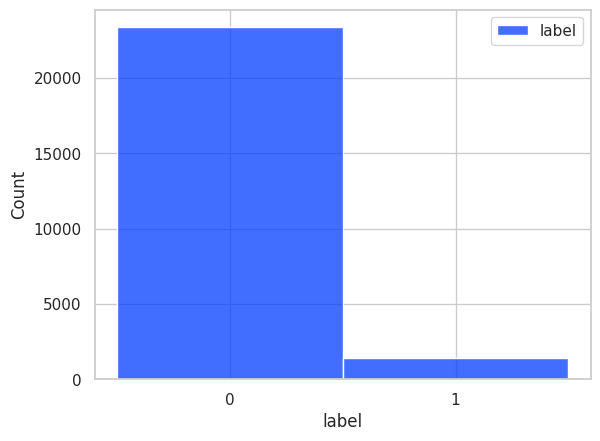

In [8]:
sns.set(style = 'whitegrid', palette='bright')
sns.histplot(pd.DataFrame(labels)['label'].apply(lambda x:str(x)), label='label')
plt.legend()

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def process_tweet(text):
    tokens = nltk.word_tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stop_words]
    return stopwords_removed

processed_data = list(map(process_tweet, df.clean_tweets))
len(processed_data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


24783

In [10]:
from nltk.probability import FreqDist
all_tokens = [item for sublist in processed_data for item in sublist]
clean_corpus_freqdist = FreqDist(all_tokens)
# top 20 words in cleaned corpus
clean_corpus_freqdist.most_common(20)

[('bitch', 8227),
 ('bitches', 3083),
 ('like', 2766),
 ('hoes', 2368),
 ('pussy', 2099),
 ('im', 2061),
 ('hoe', 1906),
 ('dont', 1749),
 ('got', 1597),
 ('ass', 1570),
 ('get', 1428),
 ('fuck', 1411),
 ('u', 1280),
 ('shit', 1262),
 ('nigga', 1198),
 ('aint', 1158),
 ('trash', 1142),
 ('lol', 1074),
 ('know', 806),
 ('niggas', 791)]

## Lemmatization

In [11]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, PorterStemmer

lemmatizer = WordNetLemmatizer()
lemmatized_data = []

for text in processed_data:
    lemmed = ' '.join([lemmatizer.lemmatize(word) for word in text])
    lemmatized_data.append(lemmed)
len(lemmatized_data)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


24783

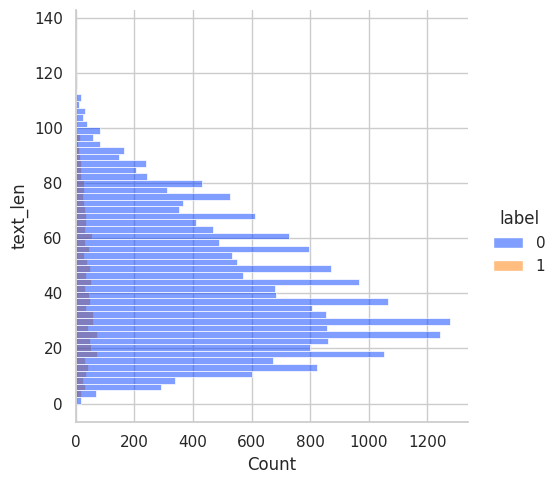

In [12]:
stats = pd.DataFrame({'text':lemmatized_data, 'label':labels})
stats['text_len'] = stats['text'].apply(lambda x:len(x))
sns.displot(stats, y='text_len', hue='label')

We can see the hatespeech has very low percentage (around 5%) in the dataset, so we'll have to do upsampling. Also majority text has a length under 60. So we'll perform padding and truncation to unsure they all have a length 60, for tensor training by deep learning models.

##Bert Tokenizer - pretrained for hate speech detection

In [13]:
from transformers import BertTokenizer, BertModel
model_name = 'Hate-speech-CNERG/bert-base-uncased-hatexplain'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert = BertModel.from_pretrained(model_name).to(device)

In [14]:
def tokenize(x):
  out = tokenizer.encode_plus(x,
        add_special_tokens=True,  # Add [CLS] and [SEP] tokens
        max_length=60,    # Truncate or pad to the maximum length
        truncation=True,          # Enable truncation if text is too long
        padding='max_length',     # Pad to the maximum length
        return_tensors='pt'       # Return PyTorch tensors)
  )

  return out

In [15]:
class NLPDataset(Dataset):
    def __init__(self, data, label) :
        super().__init__()

        self.data = data
        # print(data)
        # self.input_ids = data[:,0]
        # self.token_type_ids =data[:,1]
        # self.attention_mask = data[:,2]
        self.label = torch.LongTensor(label)

    def __len__(self):
        return self.label.shape[0]

    def __getitem__(self, index):
        # return (torch.LongTensor(self.input_ids[index]).squeeze(), \
        #         torch.LongTensor(self.attention_mask[index]).squeeze()), \
        return self.data[index],self.label[index]

In [16]:
# X_tokenized = [list(tokenize(x).values()) for x in lemmatized_data ]
X_tokenized = [tokenize(x) for x in lemmatized_data ]
# print("shape of one news:", X_tokenized[0][0].shape)
# lemmatized_data[0], label[0], X_tokenized[0]

In [17]:
att_mask = [x['attention_mask'] for  x in X_tokenized]
len(att_mask), att_mask[0]

(24783,
 tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]))

In [18]:
embeddings = []
for tokens in tqdm(X_tokenized, "Bert inferencing..."):
  tokens.to(device)
  with torch.no_grad():
      outputs = bert(**tokens)
      embeddings.append(outputs.last_hidden_state.squeeze().cpu())
embeddings[0].shape

Bert inferencing...:   0%|          | 0/24783 [00:00<?, ?it/s]

torch.Size([60, 768])

In [19]:
len(embeddings[0])

60

##Define the LSTM Model

taking these embeddings as input and perform classification.

In [20]:
config = {
    'batch_size': 128, # Increase this if your GPU can handle it
    'lr': 1e-4,
    'epochs': 30,
}

In [21]:
class NLPDataset(Dataset):
    def __init__(self, data, label) :
        super().__init__()

        self.data = data
        # print(data)
        # self.input_ids = data[:,0]
        # self.token_type_ids =data[:,1]
        # self.attention_mask = data[:,2]
        self.label = torch.LongTensor(label)

    def __len__(self):
        return self.label.shape[0]

    def __getitem__(self, index):
        # return (torch.LongTensor(self.input_ids[index]).squeeze(), \
        #         torch.LongTensor(self.attention_mask[index]).squeeze()), \
        return self.data[index],self.label[index]

In [22]:
X_train, X_test, y_train, y_test = train_test_split(np.array(embeddings), np.array(labels), test_size=0.25, random_state=42)
print("Label count:", np.unique(y_train, return_counts=True))
X_train.shape, y_train.shape

Label count: (array([0, 1]), array([17518,  1069]))


((18587,), (18587,))

### Upsampling

Label count: (array([0, 1]), array([17518, 17518]))


((35036,), (35036,))

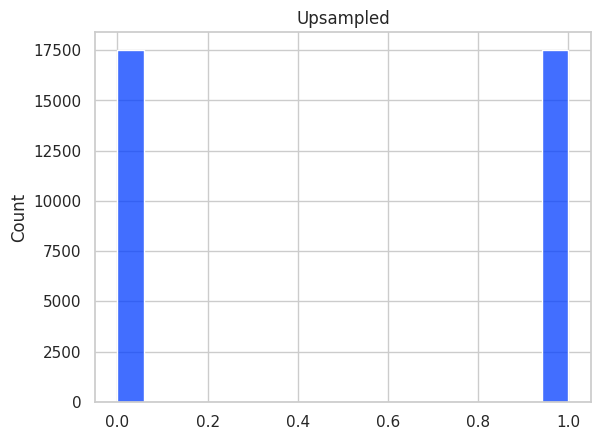

In [23]:
sm = SMOTE(random_state=42)
indices_resampled, y_train = sm.fit_resample(np.arange(X_train.shape[0])[:,np.newaxis], y_train)
X_train = np.squeeze(np.array([X_train[i] for i in indices_resampled]))
print("Label count:", np.unique(y_train, return_counts=True))
sns.histplot(y_train)
plt.title("Upsampled")
X_train.shape, y_train.shape

In [24]:
train_data = NLPDataset(X_train, y_train)
val_data = NLPDataset(X_test, y_test)
len(train_data), len(val_data)

(35036, 6196)

In [25]:
train_loader = torch.utils.data.DataLoader(
    dataset     = train_data,
    batch_size  = config['batch_size'],
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset     = val_data,
    batch_size  = config['batch_size'],
    shuffle=False
)

for batch in train_loader:
    X, y=batch
    print("Sample batch shape:", X.shape, y.shape, y)
    break

Sample batch shape: torch.Size([128, 60, 768]) torch.Size([128]) tensor([1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1])


In [26]:
# Save train data
torch.save(X_train, 'X_train.pt')
torch.save(y_train, 'y_train.pt')

# Save validation data
torch.save(X_test, 'X_val.pt')  # Assuming X_test is your validation set
torch.save(y_test, 'y_val.pt')  # Assuming y_test is your validation set labels


###LSTM

In [27]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x => [batch size, seq len, emb dim]
        x, (hidden, cell) = self.lstm(x)
        if self.lstm.bidirectional:
            x = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        else:
            x = self.dropout(hidden[-1,:,:])
        x = self.fc(x)
        return x


In [28]:
embedding_dim = 768  # Assuming you're using BERT-base
hidden_dim = 256
output_dim = 1  # Binary classification
n_layers = 2
bidirectional = True
dropout = 0.5

model = LSTMModel(embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
criterion = nn.BCEWithLogitsLoss().to(device)


In [41]:
from tqdm import tqdm
import numpy as np

def train_model(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    total_correct = 0
    all_predictions = []
    all_labels = []

    # Initialize tqdm progress bar
    batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, position=0, leave=False, desc='Train')

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X).squeeze(1)
        loss = criterion(y_pred, y.float())

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update total loss and accuracy
        total_loss += loss.item()
        predicted = torch.sigmoid(y_pred) > 0.5
        total_correct += torch.sum(predicted == y).item()

        # Collect predictions and true labels
        all_predictions.extend(predicted.int().cpu().numpy())
        all_labels.extend(y.cpu().numpy())

        # Update tqdm bar
        batch_bar.set_postfix(
            acc="{:.04f}%".format(100 * total_correct / (len(all_predictions))),
            loss="{:.04f}".format(total_loss / (len(all_predictions) / X.size(0))),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )
        batch_bar.update()

    batch_bar.close()

    # Calculate average loss and accuracy
    avg_loss = total_loss / len(train_loader)
    avg_acc = total_correct / (len(all_predictions))

    return avg_loss, avg_acc, np.array(all_predictions), np.array(all_labels)


In [49]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            predictions = model(X).squeeze(1)
            loss = criterion(predictions, y.float())

            total_loss += loss.item()
            predicted = torch.sigmoid(predictions) > 0.5
            total_correct += torch.sum(predicted == y).item()

            all_predictions.extend(predicted.int().cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    avg_acc = total_correct / (len(all_predictions))

    return avg_loss, avg_acc, np.array(all_predictions), np.array(all_labels)


###Training loop...

In [51]:
train_losses = []
train_accuracies = []
train_precision =[]
train_recall=[]

val_losses = []
val_accuracies = []
val_precision =[]
val_recall=[]

for epoch in range(config['epochs']):
    train_loss, train_acc, train_predictions, train_true_labels = train_model(model, train_loader, optimizer, criterion,device)

    # Append the metrics to their respective lists
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    train_p=precision_score(train_predictions, train_true_labels)
    train_r=recall_score(train_predictions, train_true_labels)
    train_precision.append(train_p)
    train_recall.append(train_r)

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f}, Train Precision: {train_p:.3f}, Train Recall: {train_r:.3f}')

    val_loss, val_acc, val_predictions, val_true_labels = evaluate_model(model, val_loader, criterion,device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_p=precision_score(val_predictions, val_true_labels)
    val_r=recall_score(val_predictions, val_true_labels)
    val_precision.append(val_p)
    val_recall.append(val_r)

    print(f'Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}, Val Precision: {val_p:.3f}, Val Recall: {val_r:.3f}')


Epoch: 1, Train Loss: 0.635, Train Acc: 0.618, Train Precision: 0.500, Train Recall: 0.654
Val Loss: 0.585, Val Acc: 0.810, Val Precision: 0.535, Val Recall: 0.160


Epoch: 2, Train Loss: 0.629, Train Acc: 0.624, Train Precision: 0.515, Train Recall: 0.659
Val Loss: 0.576, Val Acc: 0.826, Val Precision: 0.524, Val Recall: 0.173


Epoch: 3, Train Loss: 0.620, Train Acc: 0.637, Train Precision: 0.534, Train Recall: 0.673
Val Loss: 0.586, Val Acc: 0.799, Val Precision: 0.629, Val Recall: 0.170


Epoch: 4, Train Loss: 0.614, Train Acc: 0.643, Train Precision: 0.560, Train Recall: 0.672
Val Loss: 0.612, Val Acc: 0.764, Val Precision: 0.637, Val Recall: 0.147


Epoch: 5, Train Loss: 0.605, Train Acc: 0.652, Train Precision: 0.565, Train Recall: 0.684
Val Loss: 0.657, Val Acc: 0.671, Val Precision: 0.657, Val Recall: 0.110


Epoch: 6, Train Loss: 0.600, Train Acc: 0.657, Train Precision: 0.584, Train Recall: 0.683
Val Loss: 0.559, Val Acc: 0.785, Val Precision: 0.548, Val Recall: 0.145


Epoch: 7, Train Loss: 0.593, Train Acc: 0.665, Train Precision: 0.595, Train Recall: 0.691
Val Loss: 0.575, Val Acc: 0.752, Val Precision: 0.557, Val Recall: 0.127


Epoch: 8, Train Loss: 0.585, Train Acc: 0.673, Train Precision: 0.612, Train Recall: 0.697
Val Loss: 0.648, Val Acc: 0.677, Val Precision: 0.640, Val Recall: 0.110


Epoch: 9, Train Loss: 0.579, Train Acc: 0.680, Train Precision: 0.622, Train Recall: 0.703
Val Loss: 0.675, Val Acc: 0.629, Val Precision: 0.643, Val Recall: 0.097


Epoch: 10, Train Loss: 0.572, Train Acc: 0.685, Train Precision: 0.638, Train Recall: 0.704
Val Loss: 0.565, Val Acc: 0.764, Val Precision: 0.515, Val Recall: 0.126


Epoch: 11, Train Loss: 0.567, Train Acc: 0.688, Train Precision: 0.649, Train Recall: 0.704
Val Loss: 0.500, Val Acc: 0.819, Val Precision: 0.438, Val Recall: 0.147


Epoch: 12, Train Loss: 0.559, Train Acc: 0.696, Train Precision: 0.664, Train Recall: 0.710
Val Loss: 0.668, Val Acc: 0.651, Val Precision: 0.637, Val Recall: 0.102


Epoch: 13, Train Loss: 0.553, Train Acc: 0.701, Train Precision: 0.674, Train Recall: 0.712
Val Loss: 0.545, Val Acc: 0.769, Val Precision: 0.537, Val Recall: 0.133


Epoch: 14, Train Loss: 0.548, Train Acc: 0.701, Train Precision: 0.681, Train Recall: 0.709
Val Loss: 0.555, Val Acc: 0.750, Val Precision: 0.582, Val Recall: 0.131


Epoch: 15, Train Loss: 0.542, Train Acc: 0.709, Train Precision: 0.691, Train Recall: 0.716
Val Loss: 0.521, Val Acc: 0.781, Val Precision: 0.463, Val Recall: 0.126


Epoch: 16, Train Loss: 0.537, Train Acc: 0.709, Train Precision: 0.700, Train Recall: 0.713
Val Loss: 0.606, Val Acc: 0.688, Val Precision: 0.568, Val Recall: 0.103


Epoch: 17, Train Loss: 0.532, Train Acc: 0.715, Train Precision: 0.710, Train Recall: 0.717
Val Loss: 0.533, Val Acc: 0.760, Val Precision: 0.535, Val Recall: 0.128


Epoch: 18, Train Loss: 0.526, Train Acc: 0.717, Train Precision: 0.720, Train Recall: 0.716
Val Loss: 0.544, Val Acc: 0.726, Val Precision: 0.485, Val Recall: 0.104


Epoch: 19, Train Loss: 0.521, Train Acc: 0.717, Train Precision: 0.725, Train Recall: 0.713
Val Loss: 0.568, Val Acc: 0.719, Val Precision: 0.551, Val Recall: 0.112


Epoch: 20, Train Loss: 0.516, Train Acc: 0.722, Train Precision: 0.737, Train Recall: 0.716
Val Loss: 0.539, Val Acc: 0.719, Val Precision: 0.532, Val Recall: 0.109


Epoch: 21, Train Loss: 0.511, Train Acc: 0.724, Train Precision: 0.746, Train Recall: 0.715
Val Loss: 0.576, Val Acc: 0.691, Val Precision: 0.551, Val Recall: 0.102


Epoch: 22, Train Loss: 0.510, Train Acc: 0.725, Train Precision: 0.752, Train Recall: 0.713
Val Loss: 0.478, Val Acc: 0.796, Val Precision: 0.507, Val Recall: 0.144


Epoch: 23, Train Loss: 0.503, Train Acc: 0.726, Train Precision: 0.759, Train Recall: 0.713
Val Loss: 0.501, Val Acc: 0.769, Val Precision: 0.499, Val Recall: 0.126


Epoch: 24, Train Loss: 0.499, Train Acc: 0.729, Train Precision: 0.768, Train Recall: 0.713
Val Loss: 0.527, Val Acc: 0.745, Val Precision: 0.554, Val Recall: 0.124


Epoch: 25, Train Loss: 0.493, Train Acc: 0.732, Train Precision: 0.773, Train Recall: 0.714
Val Loss: 0.462, Val Acc: 0.776, Val Precision: 0.468, Val Recall: 0.124


Epoch: 26, Train Loss: 0.491, Train Acc: 0.736, Train Precision: 0.782, Train Recall: 0.715
Val Loss: 0.565, Val Acc: 0.690, Val Precision: 0.560, Val Recall: 0.103


Epoch: 27, Train Loss: 0.486, Train Acc: 0.735, Train Precision: 0.786, Train Recall: 0.713
Val Loss: 0.616, Val Acc: 0.653, Val Precision: 0.612, Val Recall: 0.099


Epoch: 28, Train Loss: 0.485, Train Acc: 0.735, Train Precision: 0.791, Train Recall: 0.711
Val Loss: 0.505, Val Acc: 0.756, Val Precision: 0.479, Val Recall: 0.116


Epoch: 29, Train Loss: 0.483, Train Acc: 0.735, Train Precision: 0.791, Train Recall: 0.711
Val Loss: 0.542, Val Acc: 0.709, Val Precision: 0.543, Val Recall: 0.107


Epoch: 30, Train Loss: 0.478, Train Acc: 0.738, Train Precision: 0.804, Train Recall: 0.710
Val Loss: 0.557, Val Acc: 0.706, Val Precision: 0.540, Val Recall: 0.105


###Visualizations

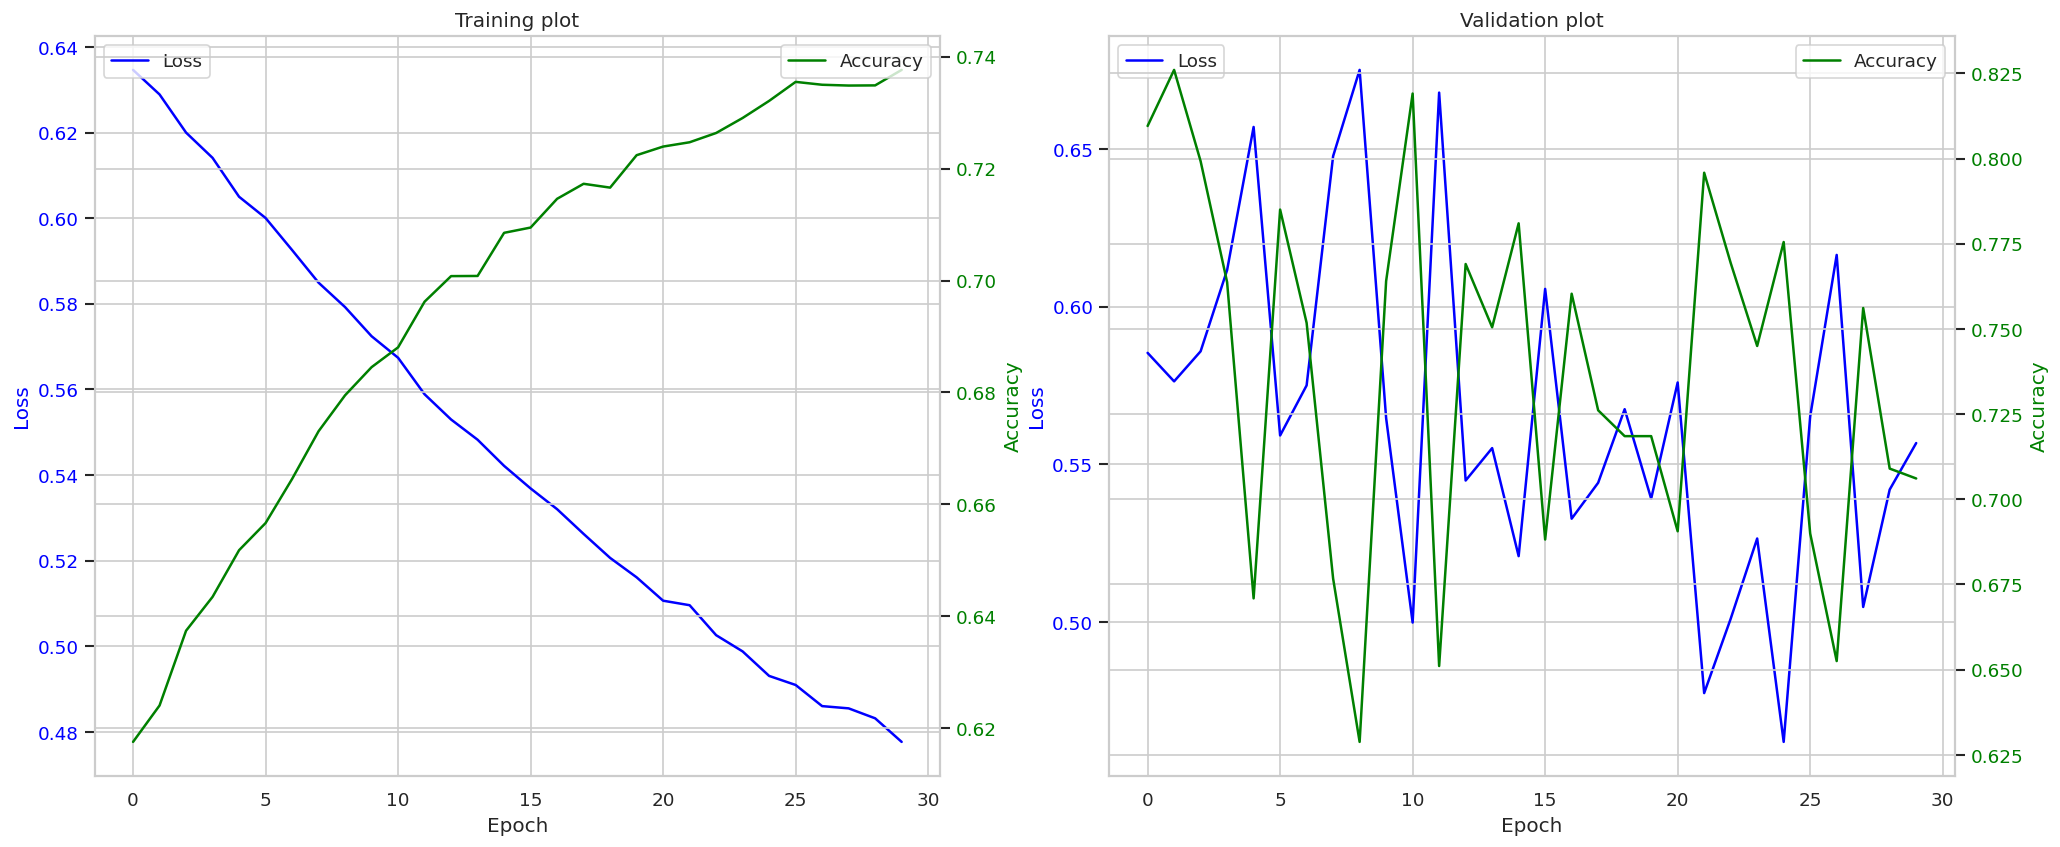

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=120)

# Training Plot
ax1 = ax[0]
ax1.plot(train_losses, label='Loss', color='blue')
ax1.set_ylabel("Loss", color='blue')
ax1.set_xlabel("Epoch")
ax1.set_title("Training plot")
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the accuracy
ax2 = ax1.twinx()
ax2.plot(train_accuracies, label='Accuracy', color='green')
ax2.set_ylabel("Accuracy", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Validation Plot
ax3 = ax[1]
ax3.plot(val_losses, label='Loss', color='blue')
ax3.set_ylabel("Loss", color='blue')
ax3.set_xlabel("Epoch")
ax3.set_title("Validation plot")
ax3.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the accuracy
ax4 = ax3.twinx()
ax4.plot(val_accuracies, label='Accuracy', color='green')
ax4.set_ylabel("Accuracy", color='green')
ax4.tick_params(axis='y', labelcolor='green')

# Adding legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax3.legend(loc='upper left')
ax4.legend(loc='upper right')

plt.show()

In [58]:
average_train_precision = np.mean(train_precision)
average_train_recall = np.mean(train_recall)
average_val_precision = np.mean(val_precision)
average_val_recall = np.mean(val_recall)

print(f"Average Train Precision: {average_train_precision:.4f}")
print(f"Average Train Recall: {average_train_recall:.4f}")
print(f"Average Validation Precision: {average_val_precision:.4f}")
print(f"Average Validation Recall: {average_val_recall:.4f}")


Average Train Precision: 0.6809
Average Train Recall: 0.7025
Average Validation Precision: 0.5508
Average Validation Recall: 0.1236


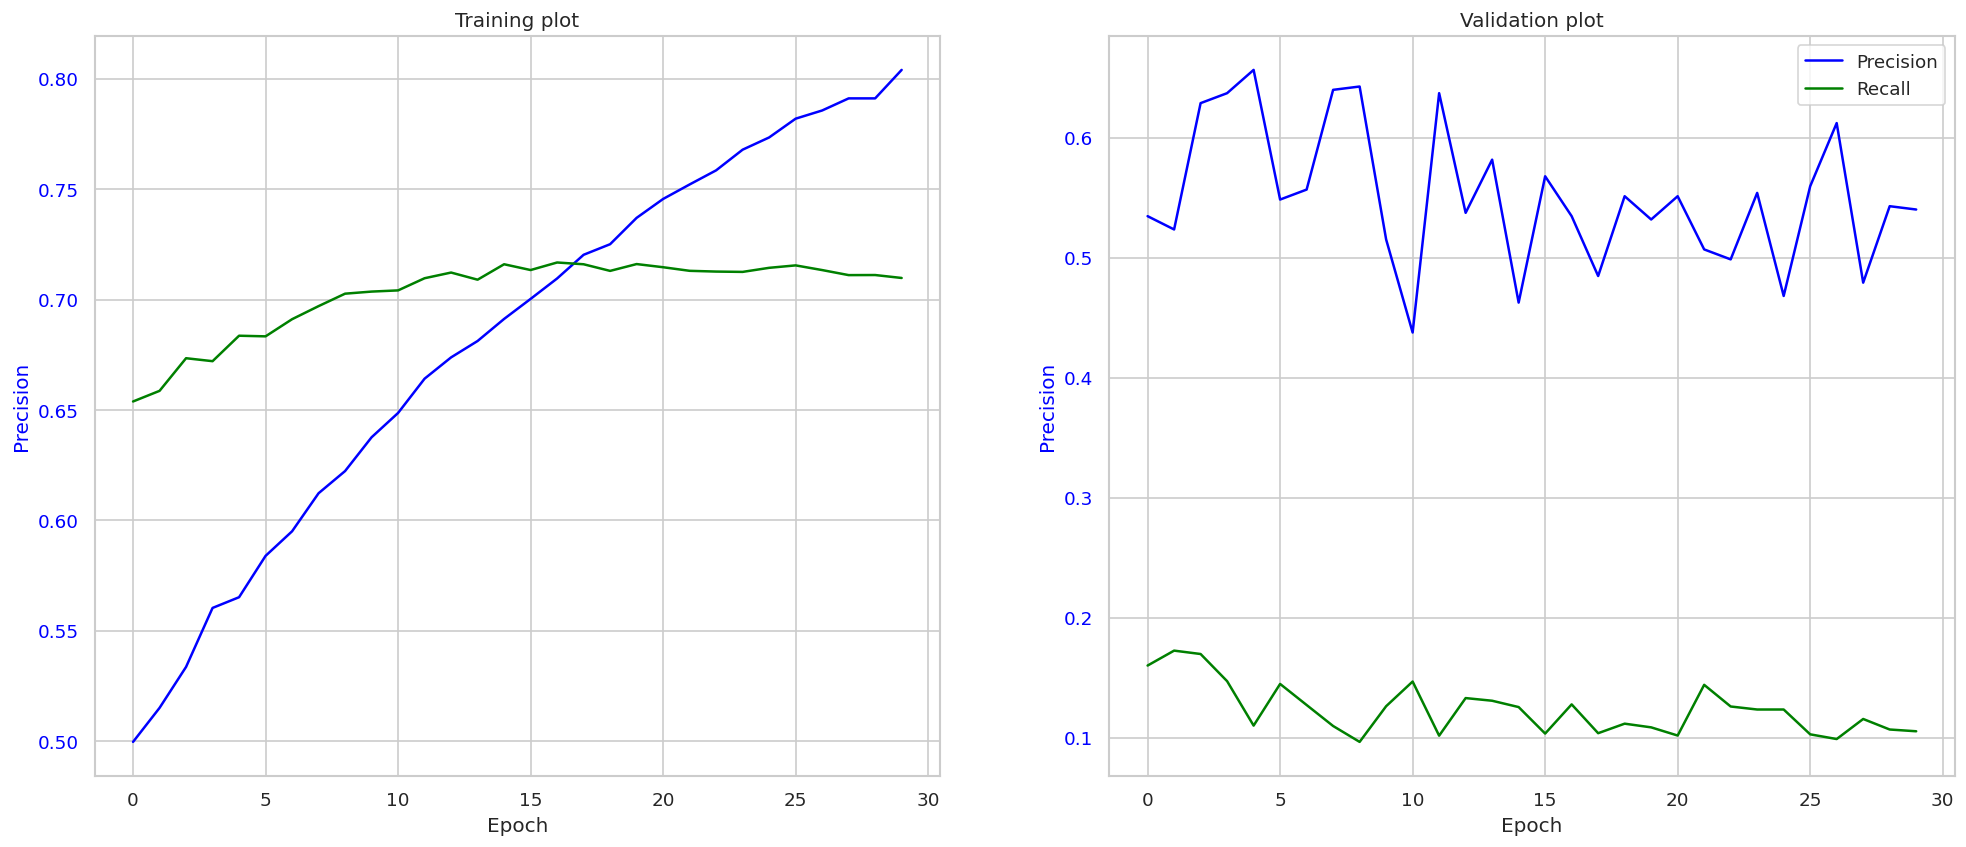

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), dpi=120)

# Training Plot
ax1 = ax[0]
ax1.plot(train_precision, label='Precision', color='blue')
ax1.plot(train_recall, label='Recall', color='green')
ax1.set_ylabel("Precision", color='blue')
ax1.set_xlabel("Epoch")
ax1.set_title("Training plot")
ax1.tick_params(axis='y', labelcolor='blue')


# Validation Plot
ax3 = ax[1]
ax3.plot(val_precision, label='Precision', color='blue')
ax3.plot(val_recall, label='Recall', color='green')
ax3.set_ylabel("Precision", color='blue')
ax3.set_xlabel("Epoch")
ax3.set_title("Validation plot")
ax3.tick_params(axis='y', labelcolor='blue')

plt.legend()

plt.show()

###Comparison with classic MLs

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X_train = np.array([np.array(x) for x in X_train])[:,0]
X_test = np.array([np.array(x) for x in X_test])[:,0]

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


Accuracy: 0.9191413815364752
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      5835
           1       0.35      0.45      0.39       361

    accuracy                           0.92      6196
   macro avg       0.66      0.70      0.67      6196
weighted avg       0.93      0.92      0.92      6196



In [55]:
import xgboost as xgb
xgb_classifier = xgb.XGBClassifier(
    max_depth=3,  # Maximum depth of each tree
    learning_rate=0.1,  # Learning rate (adjust as needed)
    n_estimators=100  # Number of boosting rounds (trees)
)
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Classification Report:")
print(report)


Accuracy: 0.7913169786959329
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.88      5835
           1       0.18      0.73      0.29       361

    accuracy                           0.79      6196
   macro avg       0.58      0.76      0.58      6196
weighted avg       0.93      0.79      0.84      6196



In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Logistic Regression model
# Note: You might need to adjust the `max_iter` parameter for convergence depending on your dataset
log_reg = LogisticRegression(max_iter=1000)

# Fit the model to the training data
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = log_reg.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
report_lr = classification_report(y_test, y_pred_lr)

print("Accuracy:", accuracy_lr)
print("Classification Report:")
print(report_lr)


Accuracy: 0.6672046481601033
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79      5835
           1       0.13      0.79      0.22       361

    accuracy                           0.67      6196
   macro avg       0.55      0.72      0.50      6196
weighted avg       0.93      0.67      0.76      6196



In [64]:
data = {
    'Model': ['LSTM', 'XGBoost', 'Random Forest', 'Logistic Regression'],
    'Precision': [0.5508, 0.18, 0.35, 0.13],  # Using macro avg precision for XGBoost and Random Forest
    'Recall': [0.1236, 0.73, 0.45, 0.79 ],  # Using macro avg recall for XGBoost and Random Forest
}

df_performance = pd.DataFrame(data)

df_performance.transpose()


,0,1,2,3
Model,LSTM,XGBoost,Random Forest,Logistic Regression
Precision,0.5508,0.18,0.35,0.13
Recall,0.1236,0.73,0.45,0.79
